In [2]:
import tensorflow as tf

import numpy as np

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd
data = pd.read_csv('dollar.csv')
data1 = data.set_index(pd.DatetimeIndex(data['날짜']))[['종가','오픈','고가','저가']]
#data2=data.set_index(pd.DatetimeIndex(data['timeUTC']))[['open']]
#data3=data.set_index(pd.DatetimeIndex(data['timeUTC']))[['close','open','high','low']]

In [4]:
data1.head()

,종가,오픈,고가,저가
날짜,,,,
2002-03-01,1318.8,1318.8,1318.8,1318.8
2002-03-04,1313.2,1325.0,1325.0,1313.2
2002-03-05,1311.4,1313.2,1313.2,1311.4
2002-03-06,1311.3,1311.4,1320.6,1311.3
2002-03-07,1309.5,1311.3,1311.3,1309.5


In [5]:
data=data1.loc['2010-03-01':]

In [6]:
data.to_csv('dollarr.csv', index=False, encoding='cp949')

/home/hj19/anaconda3/envs/spoof/lib/python3.5/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


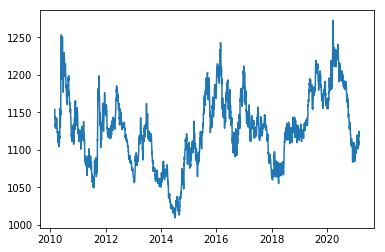

In [7]:

plt.plot(data['종가'])

In [27]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns].values.reshape(-1,4)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [28]:
train_size = int(len(scaled) * 0.8)
val_size = int(len(scaled) * 0.1)

#test_size = len(scaled) - train_size
train,val, test = scaled[0:train_size,:], scaled[train_size:train_size+val_size,:],scaled[train_size+val_size:,]
print(len(train),len(val), len(test))

2297 287 288


In [29]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [30]:
look_back = 7
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)

2290
280
281


In [31]:
print(trainX.shape)
print(trainY.shape)
#print(valX.shape)
#print(valY.shape)
print(testX.shape)
print(testY.shape)


(2290, 7, 4)
(2290,)
(281, 7, 4)
(281,)


### LSTM

In [22]:
from matplotlib import pyplot


In [56]:
model = Sequential()
model.add(Bidirectional(LSTM(150, input_shape=(7, trainX.shape[2]))))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 1, 7, 4]

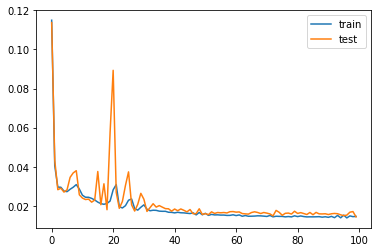

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

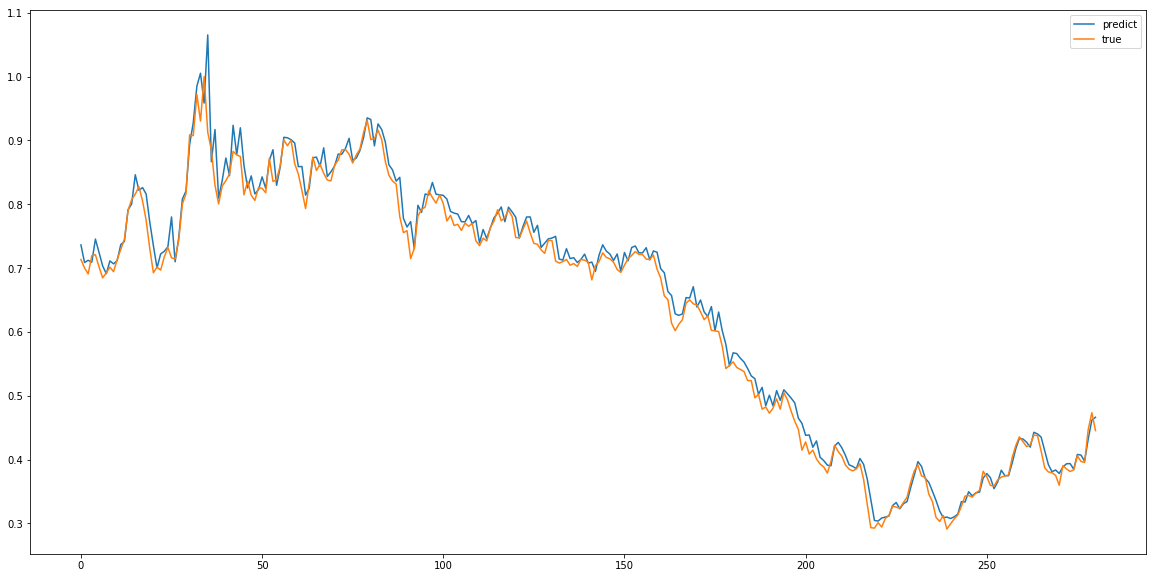

In [35]:
yhat = model.predict(testX)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [36]:
from math import *
from sklearn.metrics import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

Test RMSE: 0.02144
Test MAE: 0.01434
Test MSE: 0.00046


In [36]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1,1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [37]:
from math import *
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.796


In [37]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [48]:
trainX.shape

(2290, 1, 7, 4)

In [83]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,7,4))


in1=TimeDistributed(LSTM(150,return_sequences=True))(first_input)
#in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=400, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 2290 samples, validate on 280 samples
Epoch 1/400
2200/2290 [===========================>..] - ETA: 0s - loss: 0.0342
Epoch 00001: val_loss improved from inf to 0.00575, saving model to saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5
2290/2290 [==============================] - 2s 880us/sample - loss: 0.0330 - val_loss: 0.0058
Epoch 2/400
2200/2290 [===========================>..] - ETA: 0s - loss: 0.0034
Epoch 00002: val_loss improved from 0.00575 to 0.00129, saving model to saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5
2290/2290 [==============================] - 0s 96us/sample - loss: 0.0034 - val_loss: 0.0013
Epoch 3/400
2200/2290 [===========================>..] - ETA: 0s - loss: 0.0019
Epoch 00003: val_loss did not improve from 0.00129
2290/2290 [==============================] - 0s 87us/sample - loss: 0.0019 - val_loss: 0.0013
Epoch 4/400
2200/2290 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 00004: val_loss improved from 0.00129 to 0.0011

2200/2290 [===========================>..] - ETA: 0s - loss: 4.8579e-04
Epoch 00031: val_loss improved from 0.00026 to 0.00023, saving model to saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5
2290/2290 [==============================] - 0s 95us/sample - loss: 4.8518e-04 - val_loss: 2.2688e-04
Epoch 32/400
2200/2290 [===========================>..] - ETA: 0s - loss: 5.4979e-04
Epoch 00032: val_loss did not improve from 0.00023
2290/2290 [==============================] - 0s 89us/sample - loss: 5.4357e-04 - val_loss: 2.8205e-04
Epoch 33/400
2200/2290 [===========================>..] - ETA: 0s - loss: 4.5511e-04
Epoch 00033: val_loss improved from 0.00023 to 0.00022, saving model to saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5
2290/2290 [==============================] - 0s 96us/sample - loss: 4.5844e-04 - val_loss: 2.2316e-04
Epoch 34/400
2200/2290 [===========================>..] - ETA: 0s - loss: 4.8893e-04
Epoch 00034: val_loss did not improve from 0.00022
2290/2290 [====

Epoch 64/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.7577e-04
Epoch 00064: val_loss improved from 0.00016 to 0.00016, saving model to saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5
2290/2290 [==============================] - 0s 101us/sample - loss: 3.8009e-04 - val_loss: 1.6219e-04
Epoch 65/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.6325e-04
Epoch 00065: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 87us/sample - loss: 3.5971e-04 - val_loss: 3.9629e-04
Epoch 66/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1329e-04
Epoch 00066: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.2112e-04 - val_loss: 2.5489e-04
Epoch 67/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2163e-04
Epoch 00067: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.3147e

Epoch 98/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1661e-04
Epoch 00098: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 89us/sample - loss: 3.1317e-04 - val_loss: 1.7852e-04
Epoch 99/400
2200/2290 [===========================>..] - ETA: 0s - loss: 4.6149e-04
Epoch 00099: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 4.6534e-04 - val_loss: 2.5563e-04
Epoch 100/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.9508e-04
Epoch 00100: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.9239e-04 - val_loss: 5.0644e-04
Epoch 101/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.6717e-04
Epoch 00101: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.6793e-04 - val_loss: 2.3569e-04
Epoch 102/400
2200/2290 [=====================

Epoch 132/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.4455e-04
Epoch 00132: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.4527e-04 - val_loss: 2.3827e-04
Epoch 133/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2354e-04
Epoch 00133: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.2355e-04 - val_loss: 1.6291e-04
Epoch 134/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.0146e-04
Epoch 00134: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 87us/sample - loss: 2.9927e-04 - val_loss: 4.4545e-04
Epoch 135/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.4326e-04
Epoch 00135: val_loss did not improve from 0.00016
2290/2290 [==============================] - 0s 88us/sample - loss: 3.4128e-04 - val_loss: 2.9683e-04
Epoch 136/400
2200/2290 [===================

Epoch 166/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1630e-04
Epoch 00166: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 87us/sample - loss: 3.1542e-04 - val_loss: 6.0742e-04
Epoch 167/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.4959e-04
Epoch 00167: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.4709e-04 - val_loss: 1.5614e-04
Epoch 168/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.5125e-04
Epoch 00168: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 87us/sample - loss: 3.4746e-04 - val_loss: 1.5938e-04
Epoch 169/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2270e-04
Epoch 00169: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 86us/sample - loss: 3.1966e-04 - val_loss: 3.0196e-04
Epoch 170/400
2200/2290 [===================

Epoch 200/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2842e-04
Epoch 00200: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.2327e-04 - val_loss: 1.7789e-04
Epoch 201/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1632e-04
Epoch 00201: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.1482e-04 - val_loss: 2.4921e-04
Epoch 202/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1022e-04
Epoch 00202: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.1181e-04 - val_loss: 3.8135e-04
Epoch 203/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1841e-04
Epoch 00203: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.1690e-04 - val_loss: 1.5400e-04
Epoch 204/400
2200/2290 [===================

Epoch 234/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.0383e-04
Epoch 00234: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 87us/sample - loss: 3.0506e-04 - val_loss: 2.5015e-04
Epoch 235/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2943e-04
Epoch 00235: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.2619e-04 - val_loss: 4.4479e-04
Epoch 236/400
2200/2290 [===========================>..] - ETA: 0s - loss: 4.9371e-04
Epoch 00236: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 87us/sample - loss: 4.8516e-04 - val_loss: 7.0243e-04
Epoch 237/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.4273e-04
Epoch 00237: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 87us/sample - loss: 3.4236e-04 - val_loss: 1.5604e-04
Epoch 238/400
2200/2290 [===================

Epoch 268/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1158e-04
Epoch 00268: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.1167e-04 - val_loss: 1.6359e-04
Epoch 269/400
2200/2290 [===========================>..] - ETA: 0s - loss: 2.9721e-04
Epoch 00269: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 89us/sample - loss: 3.0075e-04 - val_loss: 1.5425e-04
Epoch 270/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.0264e-04
Epoch 00270: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 91us/sample - loss: 3.0371e-04 - val_loss: 1.7712e-04
Epoch 271/400
2200/2290 [===========================>..] - ETA: 0s - loss: 4.7113e-04
Epoch 00271: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 86us/sample - loss: 4.8251e-04 - val_loss: 4.9305e-04
Epoch 272/400
2200/2290 [===================

2200/2290 [===========================>..] - ETA: 0s - loss: 3.0493e-04
Epoch 00302: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 88us/sample - loss: 3.0754e-04 - val_loss: 2.5190e-04
Epoch 303/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2934e-04
Epoch 00303: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 89us/sample - loss: 3.2840e-04 - val_loss: 4.1008e-04
Epoch 304/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2861e-04
Epoch 00304: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 89us/sample - loss: 3.3029e-04 - val_loss: 1.6301e-04
Epoch 305/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.4736e-04
Epoch 00305: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.4186e-04 - val_loss: 2.5098e-04
Epoch 306/400
2200/2290 [===========================>..] -

2200/2290 [===========================>..] - ETA: 0s - loss: 3.0681e-04
Epoch 00336: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.0792e-04 - val_loss: 1.5459e-04
Epoch 337/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1132e-04
Epoch 00337: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 89us/sample - loss: 3.1349e-04 - val_loss: 4.4345e-04
Epoch 338/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1127e-04
Epoch 00338: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 89us/sample - loss: 3.0988e-04 - val_loss: 1.6055e-04
Epoch 339/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.2881e-04
Epoch 00339: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.2808e-04 - val_loss: 5.3242e-04
Epoch 340/400
2200/2290 [===========================>..] -

2200/2290 [===========================>..] - ETA: 0s - loss: 3.0294e-04
Epoch 00370: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 2.9988e-04 - val_loss: 1.7542e-04
Epoch 371/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.3176e-04
Epoch 00371: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.2859e-04 - val_loss: 2.1662e-04
Epoch 372/400
2200/2290 [===========================>..] - ETA: 0s - loss: 2.8697e-04
Epoch 00372: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 2.8759e-04 - val_loss: 1.5966e-04
Epoch 373/400
2200/2290 [===========================>..] - ETA: 0s - loss: 3.1738e-04
Epoch 00373: val_loss did not improve from 0.00015
2290/2290 [==============================] - 0s 90us/sample - loss: 3.3232e-04 - val_loss: 2.0936e-04
Epoch 374/400
2200/2290 [===========================>..] -

In [84]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, 7, 4)]      0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 7, 150)      93000     
_________________________________________________________________
time_distributed_54 (TimeDis (None, None, 6, 64)       19264     
_________________________________________________________________
time_distributed_55 (TimeDis (None, None, 6, 64)       4160      
_________________________________________________________________
time_distributed_56 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, None, 192)         0         
_________________________________________________________________
dense_15 (Dense)             (None, None, 1)           193 

In [85]:
model.load_weights("saved_weights/dollar_lstmconv1d_timedist150_2_1.hdf5")

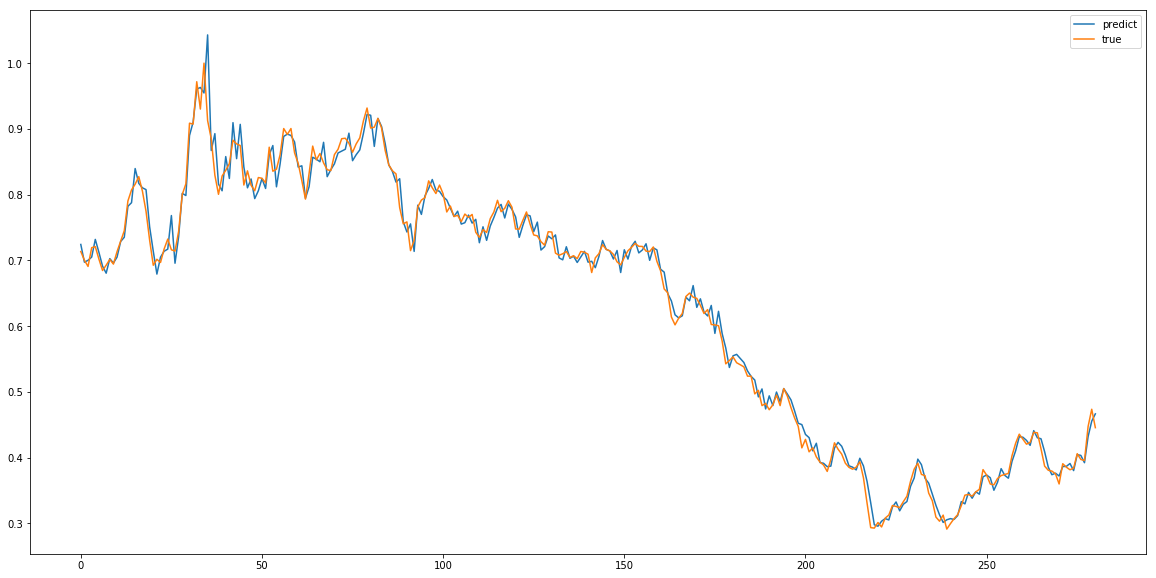

Test RMSE: 0.01674
Test MAE: 0.01179
Test MSE: 0.00028


In [86]:
yhat = model.predict(testX)
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
from sklearn.metrics import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

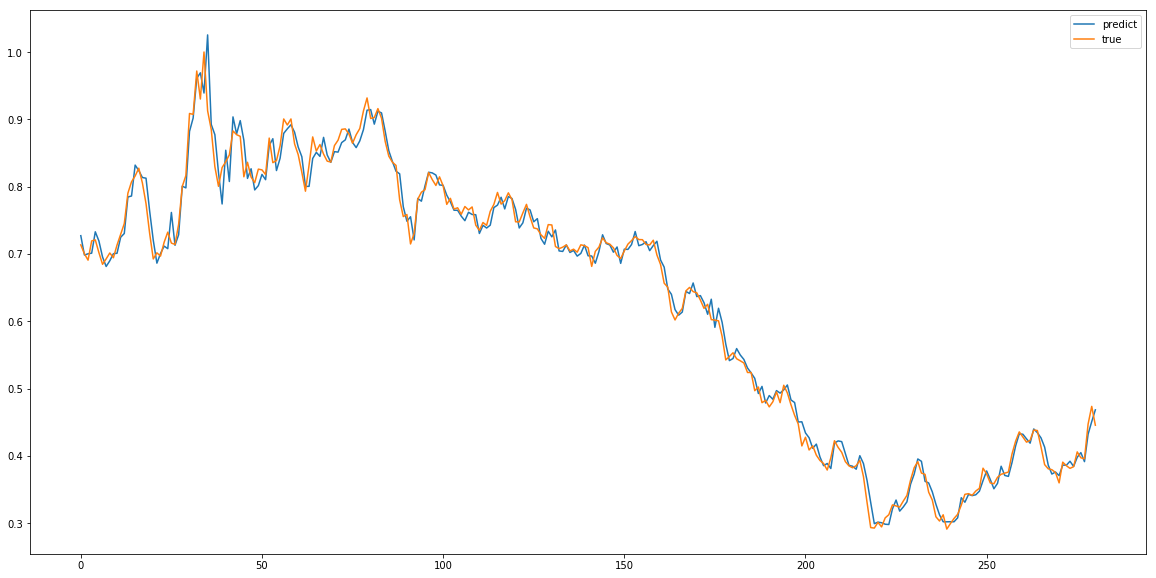

In [81]:
yhat = model.predict(testX)
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()



In [82]:
from math import *
from sklearn.metrics import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

Test RMSE: 0.01702
Test MAE: 0.01232
Test MSE: 0.00029


### gru

In [200]:
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

7998
1995


In [201]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1 ))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

In [202]:
print(trainX.shape)

(7998, 6, 1)


In [203]:
print(testX.shape)

(1995, 6, 1)


In [38]:
model = Sequential()
model.add(GRU(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history1 = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

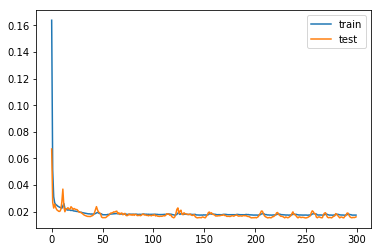

In [39]:
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

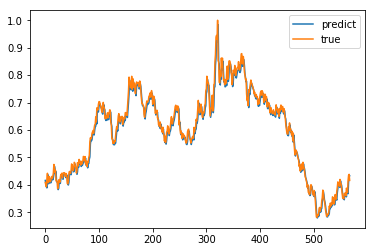

In [40]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [41]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [42]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.698


## stacked

In [43]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True))

multi_model.add(LSTM(64))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

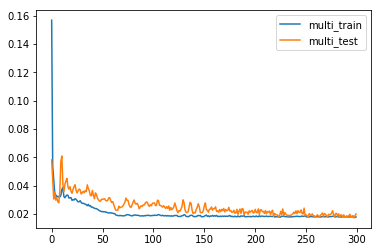

In [44]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

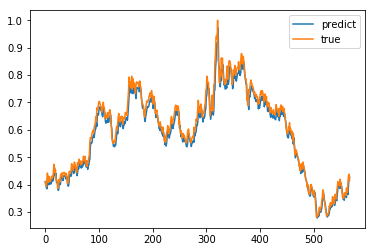

In [45]:
yhat = multi_model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [46]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [47]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.828
